<a href="https://colab.research.google.com/github/domingues100/Water-Level-Detection---IA/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **Drive**

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# IMPORTS

In [ ]:
import os
from shutil import copy2
import csv
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
tf.__version__
import pandas as pd
import PIL
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten
from keras.models import Sequential
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import gc
import statistics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report

# **KFOLD**

In [ ]:
train_data = pd.read_csv('PATH CSV')

for ind in train_data.index:

   train_data['label'][ind] = (train_data['label'][ind] - 3 ) #classes are 3, 4, 5, 6, 7 -> 0, 1, 2, 3, 4

train_data['label']=train_data["label"].values.astype(str)

Y = train_data[['label']]


In [ ]:
image_dir = "IMAGE PATH"

#Define kfold

skf = StratifiedKFold(n_splits = 10, random_state = 7, shuffle = True)

#Define epochs

num_epochs = 150

We don’t need to create X, because as mentioned in the documentation page for StratifiedKFold , it is sufficient to provide only the labels Y to generate the splits and hence we can put np.zeros(n_samples) instead of X.


In [ ]:
#Image Data Generator

idg = ImageDataGenerator(width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)

# just to save weights name

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
predicted = []
validation_data1 = []


save_dir = "SAVE DIRECTORY"
fold_var = 1

n = Y.size

for train_index, val_index in skf.split(np.zeros(n),Y):
  training_data = train_data.iloc[train_index]
  validation_data = train_data.iloc[val_index]
  validation_data1.append(validation_data)

  training_data.to_csv(f"{save_dir}/training_data{fold_var}.csv") #saves training_data in a csv
  validation_data.to_csv(f"{save_dir}/validation_data{fold_var}.csv") #saves validation_data in a csv

  train_data_generator = idg.flow_from_dataframe(training_data, directory = image_dir,
						       x_col = "id", y_col = "label",
						       class_mode = "categorical", shuffle = True)

  valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
							x_col = "id", y_col = "label",
							class_mode = "categorical", shuffle = False)

  model = keras.Sequential([
      hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5",
                     output_shape=[1280],
                     trainable=False),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(5, activation='softmax')])


  model.build([None, 224, 224, 3])

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

	# COMPILE NEW MODEL
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

	# CREATE CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
  callbacks_list = [checkpoint]


	# FIT THE MODEL
  history = model.fit(train_data_generator, epochs=num_epochs, callbacks=callbacks_list, validation_data=valid_data_generator)

	# LOAD MODEL
  model.load_weights(f"{save_dir}/model_"+str(fold_var)+".h5")

  results = model.evaluate(valid_data_generator)
  results = dict(zip(model.metrics_names,results))

  pred = model.predict(valid_data_generator)
  predicted.append(np.argmax(pred,axis=1))

  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])

  tf.keras.backend.clear_session()

  fold_var += 1
  gc.collect()

# Load Model

Necessary run diretory cells and idg before



In [ ]:
from keras.models import load_model

model = keras.Sequential([
      hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5",
                     output_shape=[1280],
                     trainable=False),
      keras.layers.Dropout(0.4),
      keras.layers.Dense(5, activation='softmax')])

model.build([None, 224, 224, 3])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
var = 1
accuracy = []
k=0

for k in range(10):

  validation_data = pd.read_csv("PATH WITH VALIDATION CSV")
  for ind in validation_data.index:
    validation_data['label'][ind] = (validation_data['label'][ind] - 3 )

  validation_data['label']=validation_data["label"].values.astype(str)

  valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = image_dir,
                x_col = "image_name", y_col = "category",
                class_mode = "categorical", shuffle = False)

  model.load_weights(f"{save_dir}/model_{k+1}.h5")
  pred = model.predict(valid_data_generator)
  predicted = np.argmax(pred,axis=1)
  i = 0

  for itens in validation_data:
    val_data = validation_data["label"] .values.tolist()


  val_data = list(map(int, val_data))
  print(val_data)
  j=0
  resultado = 0
  for elements in val_data:
    if val_data[j] == predicted[j]:
      resultado += 1
    j += 1

  accuracy.append(resultado/len(val_data))
  k += 1

  dados = {"predicted": predicted, "label": val_data}

  df = pd.DataFrame(dados)
  df.to_csv(f"PATH TO SAVE/df{k}.csv")


# Predição

In [ ]:
#MAE, MSE, R2

erro = []
erro2 = []
erro3 = []

for number in range(1,11):
  dados = pd.read_csv(f"PATH TO SAVED PREDICTIONS/df{number}.csv")

  for ind in dados.index:
   dados['label'][ind] = (dados['label'][ind] + 3 )
   dados['predicted'][ind] = (dados['predicted'][ind] + 3 )

  predicted = dados["predicted"].tolist()
  label = dados["label"].tolist()
  erro.append(mean_absolute_error(predicted, label))
  erro2.append(mean_squared_error(predicted, label))
  erro3.append(r2_score(predicted,label))

In [ ]:
df = pd.DataFrame(erro,columns = ["EMA"])
df['EMQ'] = erro2
df['r2'] = erro3
iteracoes = ["1", '2', '3', '4', '5', '6', '7', '8', '9', '10']
df["Iterações"] = iteracoes

In [ ]:
print(statistics.mean(erro))
print(statistics.mean(erro2))
print(statistics.mean(erro3))

In [ ]:
#Necessary put all the preds in the same csv or run multiple times

dados = pd.read_csv("CSV WITH ALL PRED FOR K")
target_names = ['3', '4', '5', '6', '7']
predicted = dados["predicted"].tolist()
label = dados["label"].tolist()

print(classification_report(label, predicted , target_names=target_names))

              precision    recall  f1-score   support

           3       0.93      0.96      0.94        26
           4       0.86      0.81      0.83        37
           5       0.81      0.75      0.78        40
           6       0.89      0.83      0.86        48
           7       0.83      0.92      0.87        63

    accuracy                           0.86       214
   macro avg       0.86      0.86      0.86       214
weighted avg       0.86      0.86      0.85       214



# contagem

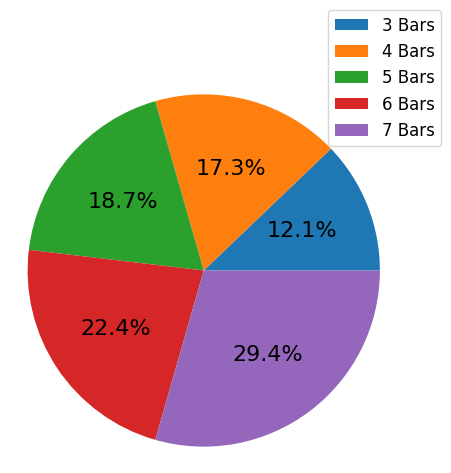

In [11]:
import matplotlib.pyplot as plt

class_3 = 26
class_4 = 37
class_5 = 40
class_6 = 48
class_7 = 63

# Dados de exemplo
labels = ['3 Bars', '4 Bars', '5 Bars', '6 Bars', '7 Bars']
sizes = [class_3, class_4, class_5, class_6, class_7]

# Cria o gráfico de pizza
fig1, ax1 = plt.subplots(figsize = (5,5))
ax1.pie(sizes, autopct='%1.1f%%')
plt.legend(labels, loc='center left', bbox_to_anchor=(0.8, 1), fontsize=12)
ax1.axis('equal')
for text in ax1.texts:
    text.set_fontsize(16)
plt.savefig('pizza.pdf', dpi=100)

plt.show()

***confusion matrix plot***

In [15]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/IC_Machine_Learning/Model_Save/Resultados/Planilha_todas_pred.csv")

y_test = df['label'].tolist()
y_pred = df['predicted'].tolist()

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
labels = ['3', '4', '5', '6', '7']
plt.figure(figsize=(4, 3))

plt.rcParams.update({'font.size': 16})
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,cmap=plt.cm.Blues,colorbar = False)
fig = disp.ax_.get_figure()
fig.set_figwidth(3)
fig.set_figheight(3)
ax.set_xlabel('Eixo X', fontsize=16)
ax.set_ylabel('Eixo Y', fontsize=16)


plt.gcf().axes[0].tick_params(labelsize=12)
plt.show()
plt.savefig('matriz_classification.pdf', dpi=160, bbox_inches='tight', pad_inches=0.1, format='pdf')
plt.close()

# Boxplot



In [ ]:
# Load package
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Creating dataset
df = pd.read_csv("/content/drive/MyDrive/IC_Machine_Learning/Model_Save/Resultados/Planilha_todas_pred.csv")

# plot
plt.boxplot(df['predicted'],boxprops=dict(color='red'))
plt.title('Simple Boxplot');